In [107]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as data
import pandas as pd
from scipy.stats import t, norm
import statsmodels.api as sm
np.random.seed(0)

Gỉa sử có một biến ngẫu nhiên Y theo phân phối N nào đó

X là ma trận chứa p feature tương ứng với quan sát y

In [108]:
# X, y = data.load_diabetes(return_X_y=True)
# X, y = data.make_regression(n_samples=1000,n_features=10,noise=10)




n = 500
p = 5
iter = 5000


# X = np.random.normal(size = (n, p))
# y = np.random.normal(size = (n, 1))
# X = sm.add_constant(X)
def create_data(n, p):
    mu = 10
    noise = np.random.normal(0, 1, size = (n, 1))
    y = mu + noise
    return y

X = np.random.normal(0, 1, size = (n, p))
X = sm.add_constant(X)

def model_fit(n, p):
    y = create_data(n, p)
    global X
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

    return X, y, beta_hat


def calculate_p_value(X, y, beta_hat):
    residual = y - X @  beta_hat
    sigma_squared = (residual.T @ residual) / (n - p)
    var_beta_hat = sigma_squared * np.linalg.inv(X.T @ X)
    se_beta = np.sqrt(np.diag(var_beta_hat))
    t_stats = beta_hat.flatten() / se_beta
    p_values = 2 * (1 - t.cdf(np.abs(t_stats), df = n - p))

    return p_values

def record_p_values(n, p, iter):
    p_values_list = []
    beta_hat_list = []
    for _ in range(iter):
        X, y, beta_hat = model_fit(n, p)
        p_values = calculate_p_value(X, y, beta_hat)

        beta_hat_list.append(beta_hat.flatten())
        p_values_list.append(p_values)

    return p_values_list, beta_hat_list

p_value_list, beta_hat_list = record_p_values(n, p, iter)


pvalues_df = pd.DataFrame(p_value_list, columns=['Intercept'] + [f'X{i + 1}' for i in range(p)])




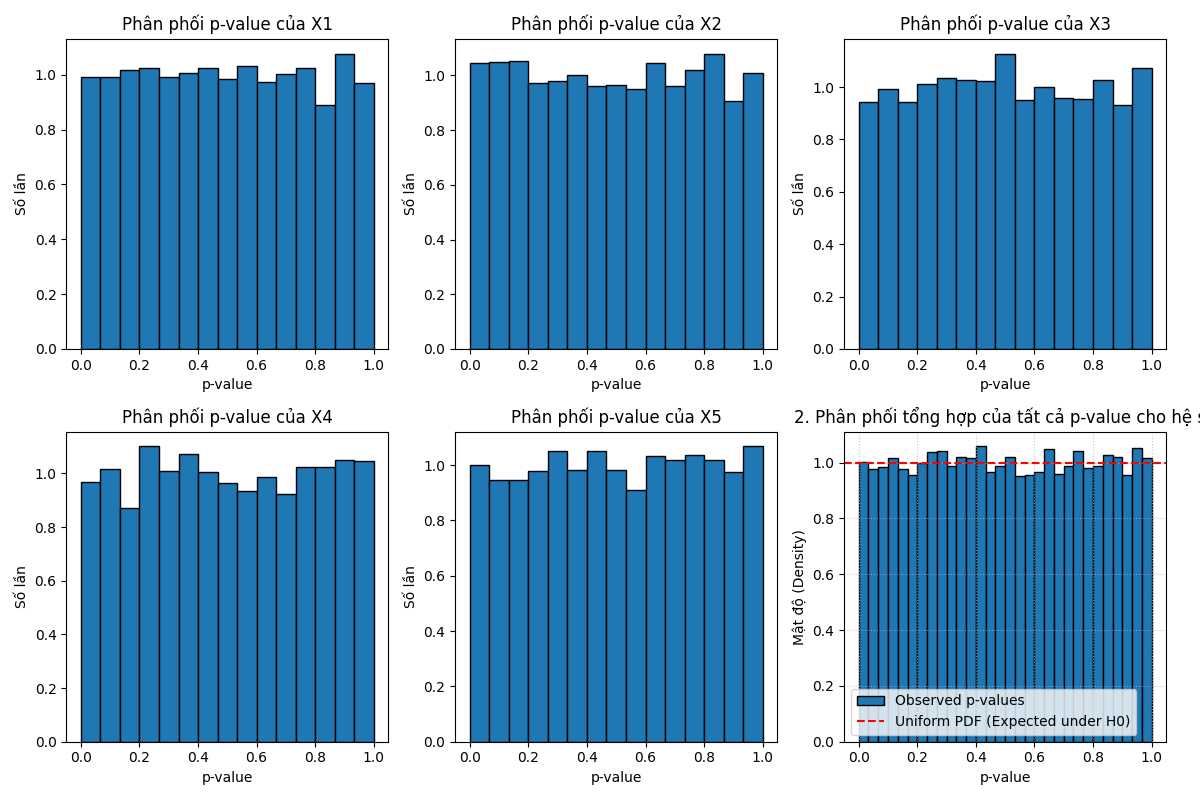

In [109]:
slope_columns = pvalues_df.columns[1:]


fig, axes = plt.subplots(2, 3, figsize = (12, 8))
axes = axes.flatten()

for idx, col in enumerate(slope_columns):
    axes[idx].hist(pvalues_df[col], bins = 15, density = True,edgecolor = 'black', range = (0, 1))
    axes[idx].set_title(f'Phân phối p-value của {col}')
    axes[idx].set_xlabel('p-value')
    axes[idx].set_ylabel('Số lần')

all_slope_p_values = pvalues_df[slope_columns].values.flatten()

axes[5].hist(all_slope_p_values, bins=30, range=(0,1), density=True, edgecolor='black', label='Observed p-values')
axes[5].axhline(1, color='red', linestyle='--', label='Uniform PDF (Expected under H0)')
axes[5].set_title('2. Phân phối tổng hợp của tất cả p-value cho hệ số')
axes[5].set_xlabel('p-value')
axes[5].set_ylabel('Mật độ (Density)')
axes[5].legend()
axes[5].grid(True, linestyle=':', alpha=0.7)


plt.tight_layout()

=> Chỉ khi X và y phân phối độc lập nhau thì p value uniform

Index(['beta1', 'beta2', 'beta3', 'beta4', 'beta5'], dtype='object')
0       0.034527
1      -0.010382
2      -0.068769
3      -0.044026
4       0.073968
          ...   
4995    0.036384
4996    0.011460
4997    0.099182
4998   -0.055259
4999   -0.026506
Name: beta1, Length: 5000, dtype: float64


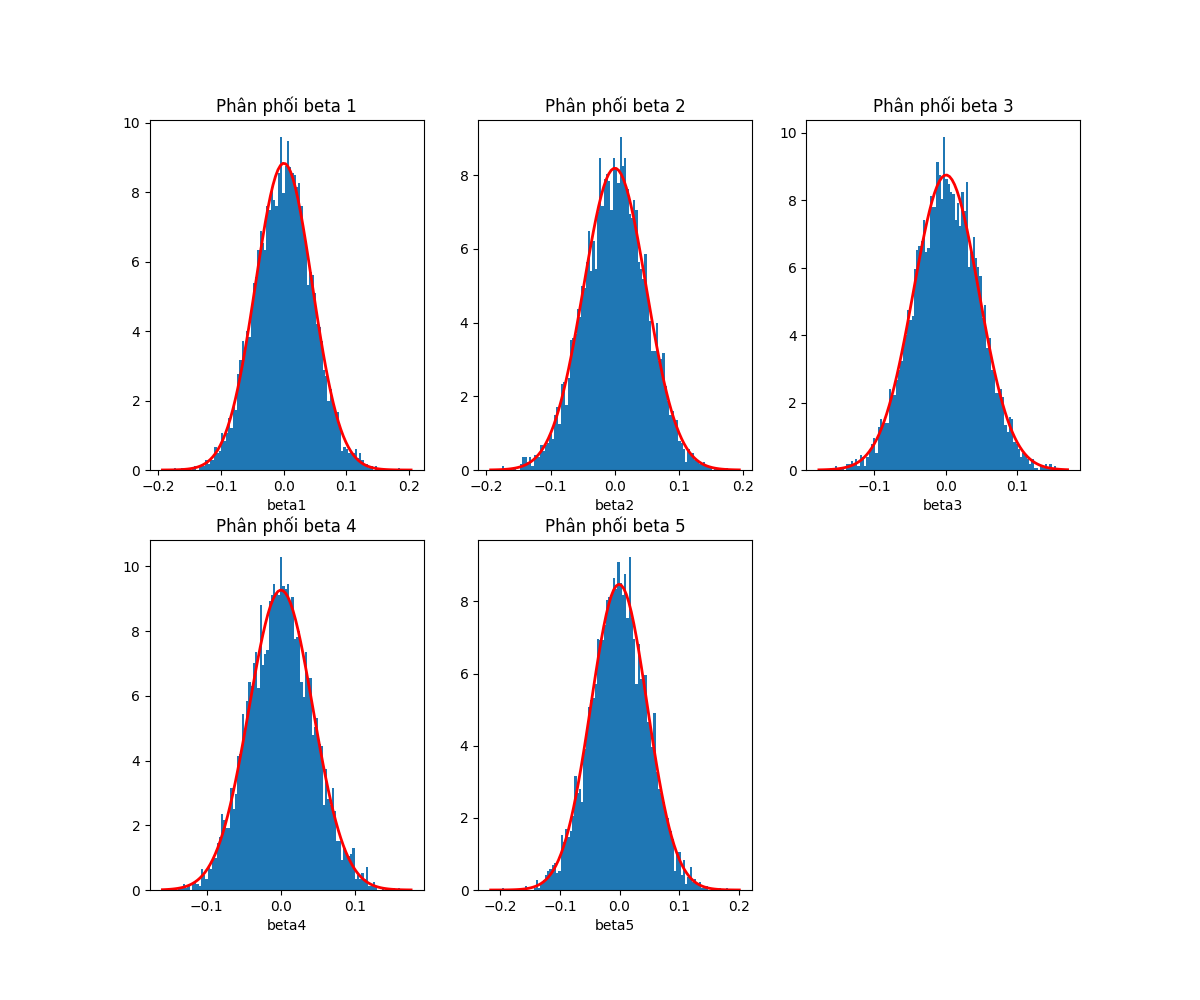

In [110]:
fig, axes = plt.subplots(2, 3, figsize = (12,10))
axes = axes.flatten()
beta_hat_df = pd.DataFrame(beta_hat_list, columns = ['Intercept'] + [f'beta{i + 1}' for i in range(p)])

slope_columns = beta_hat_df.columns[1:]
print(slope_columns)
print(beta_hat_df['beta1'])
for idx, col in enumerate(slope_columns):
    axes[idx].hist(beta_hat_df[col],bins = 100,density = True)
    axes[idx].set_title(f'Phân phối beta {idx + 1}')
    axes[idx].set_xlabel(slope_columns[idx])

    mu, std = norm.fit(beta_hat_df[col])
    xmin, xmax = axes[idx].get_xlim()
    x_norm = np.linspace(xmin, xmax, 100)
    p_norm = norm.pdf(x_norm, mu, std)

    axes[idx].plot(x_norm, p_norm, 'r-', linewidth=2, label=f'Fit N({mu:.2f}, {std:.2f})')

plt.delaxes(axes[5])